In [3]:
!pip install scikeras

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39644 entries, 0 to 39643
Data columns (total 61 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   url                            39644 non-null  object 
 1   timedelta                      39644 non-null  float64
 2   n_tokens_title                 39644 non-null  float64
 3   n_tokens_content               39644 non-null  float64
 4   n_unique_tokens                39644 non-null  float64
 5   n_non_stop_words               39644 non-null  float64
 6   n_non_stop_unique_tokens       39644 non-null  float64
 7   num_hrefs                      39644 non-null  float64
 8   num_self_hrefs                 39644 non-null  float64
 9   num_imgs                       39644 non-null  float64
 10  num_videos                     39644 non-null  float64
 11  average_token_length           39644 non-null  float64
 12  num_keywords             

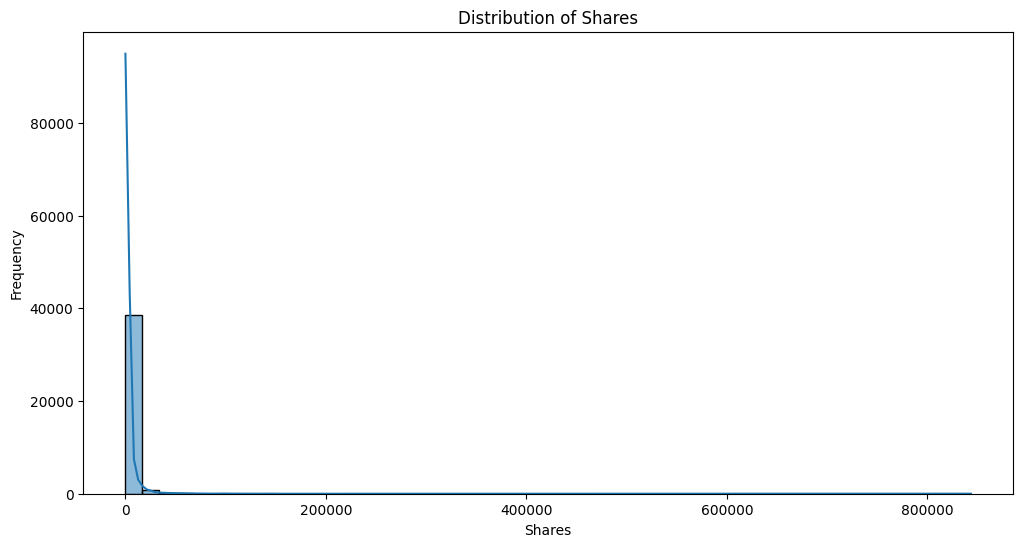

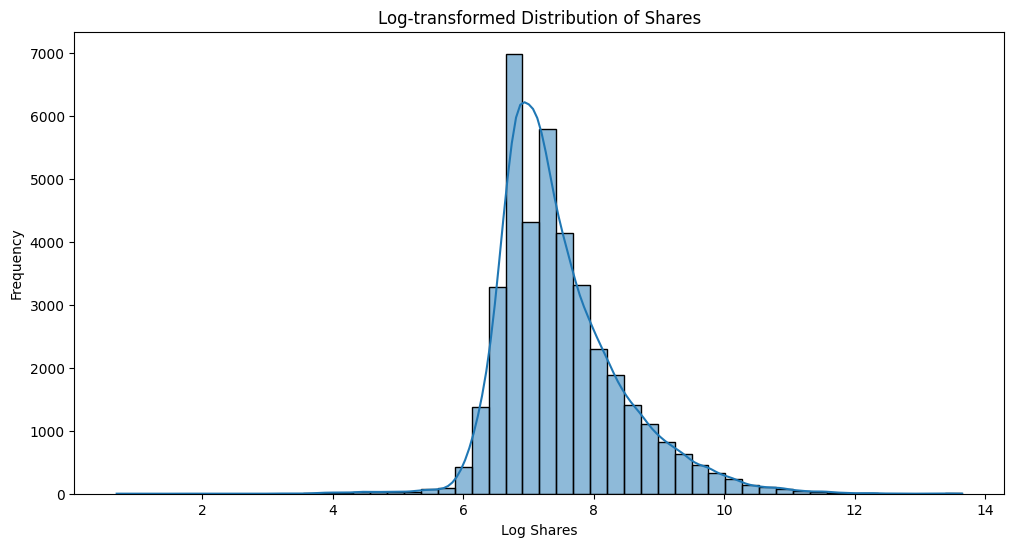

Optimal lambda for Box-Cox: -0.21964795585426122


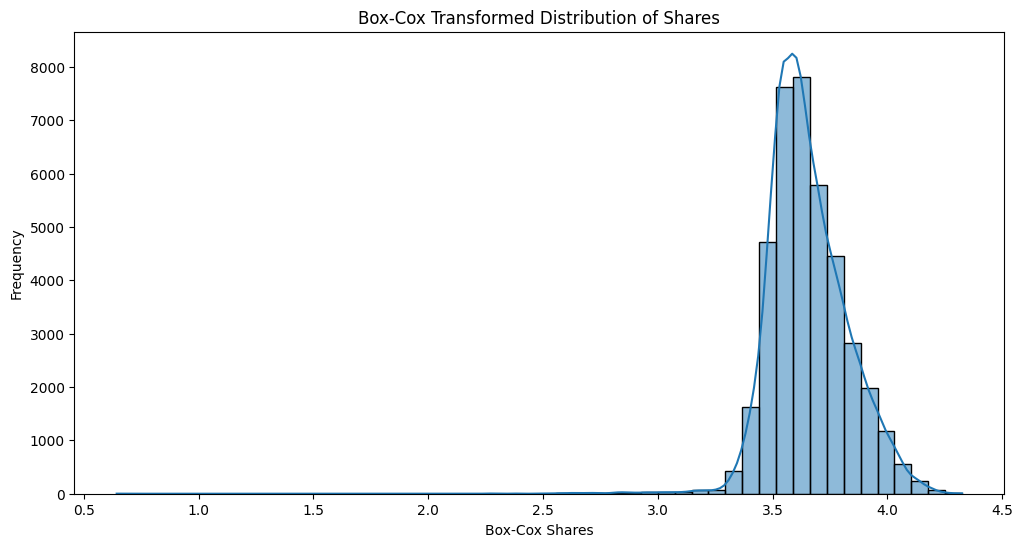

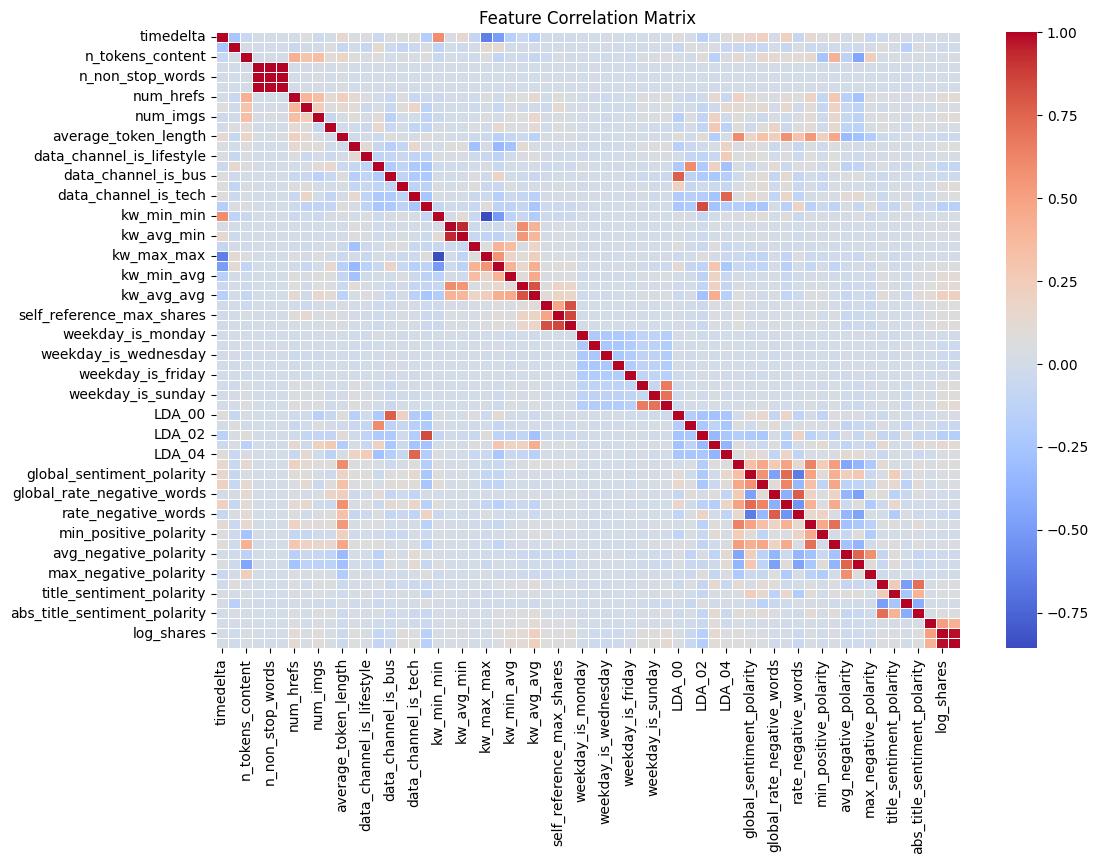

Top correlated feature pairs (excluding self-correlation):
n_non_stop_unique_tokens  n_unique_tokens             0.999852
n_unique_tokens           n_non_stop_unique_tokens    0.999852
                          n_non_stop_words            0.999572
n_non_stop_words          n_unique_tokens             0.999572
                          n_non_stop_unique_tokens    0.999532
n_non_stop_unique_tokens  n_non_stop_words            0.999532
boxcox_shares             log_shares                  0.981244
log_shares                boxcox_shares               0.981244
kw_max_min                kw_avg_min                  0.940529
kw_avg_min                kw_max_min                  0.940529
dtype: float64


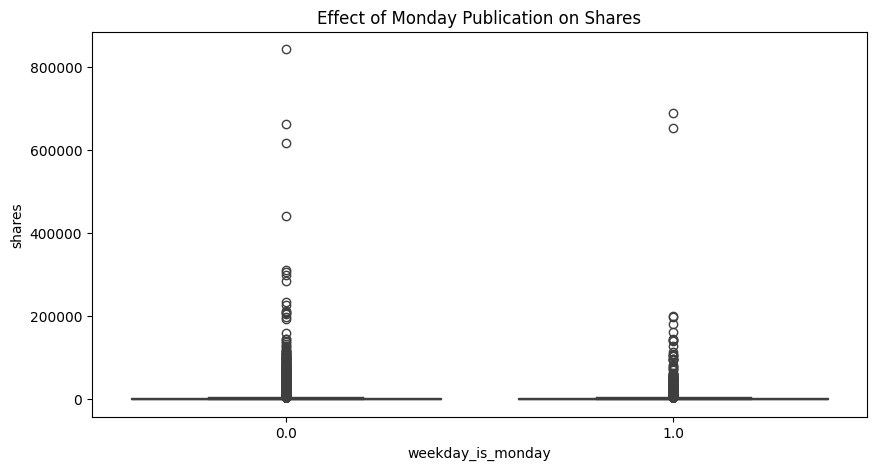

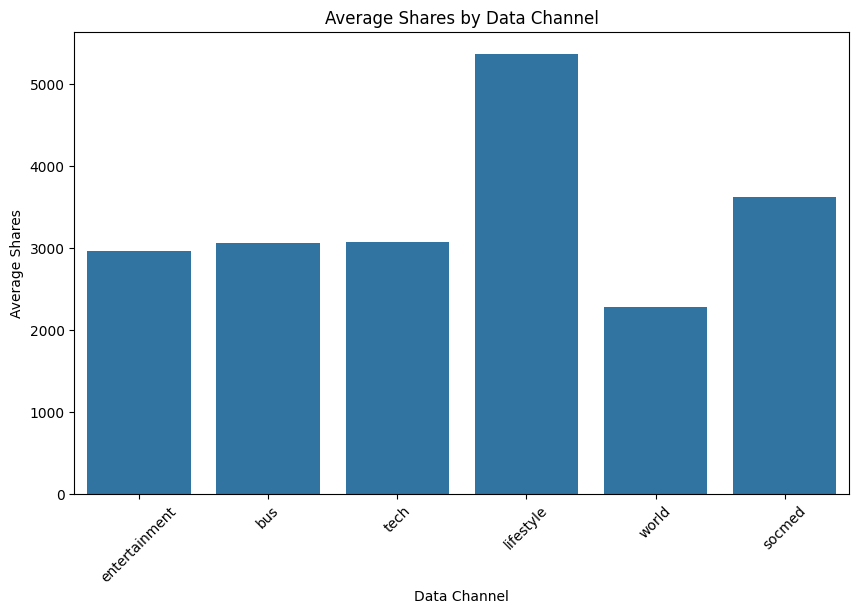

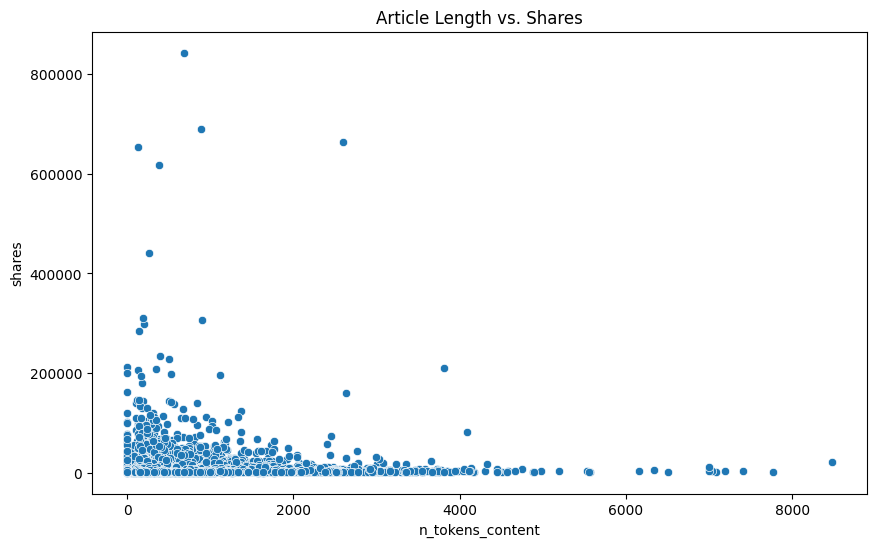

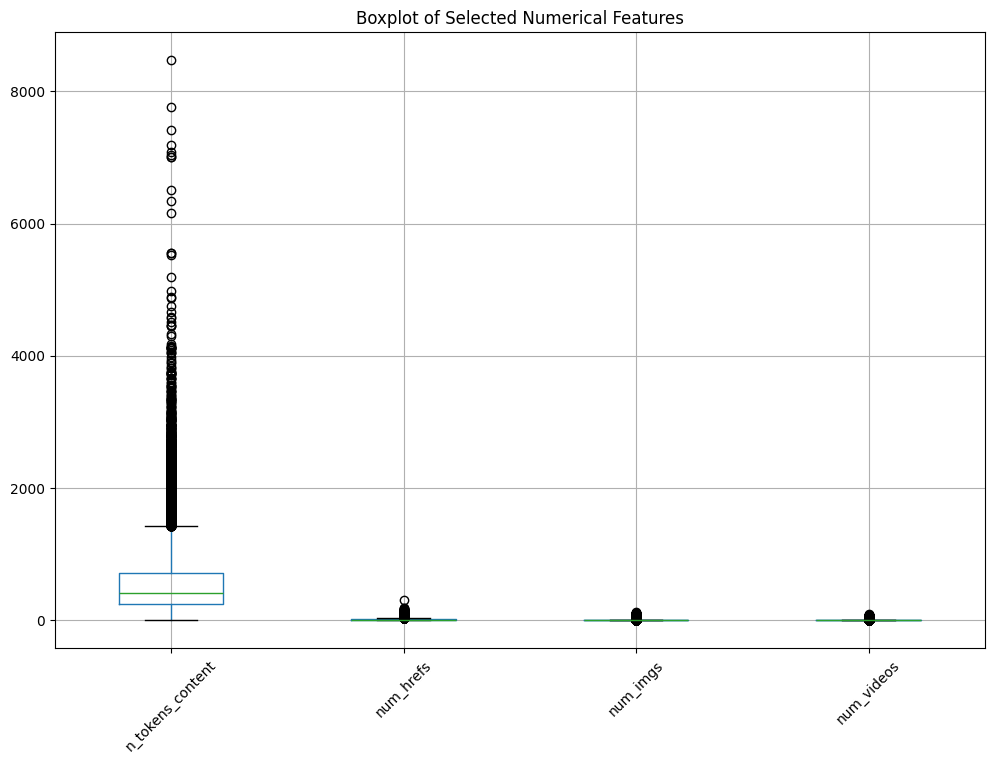

Number of outliers using IQR: 4541
Number of outliers using Z-score: 308
shares                        1.000000
log_shares                    0.510181
boxcox_shares                 0.416169
kw_avg_avg                    0.110413
LDA_03                        0.083771
kw_max_avg                    0.064306
self_reference_avg_sharess    0.057789
self_reference_min_shares     0.055958
self_reference_max_shares     0.047115
num_hrefs                     0.045404
kw_avg_max                    0.044686
kw_min_avg                    0.039551
num_imgs                      0.039388
global_subjectivity           0.031604
kw_avg_min                    0.030406
Name: shares, dtype: float64
rate_negative_words             -0.005183
weekday_is_tuesday              -0.007941
weekday_is_thursday             -0.008833
LDA_01                          -0.010183
data_channel_is_bus             -0.012376
rate_positive_words             -0.013241
data_channel_is_tech            -0.013253
LDA_04             

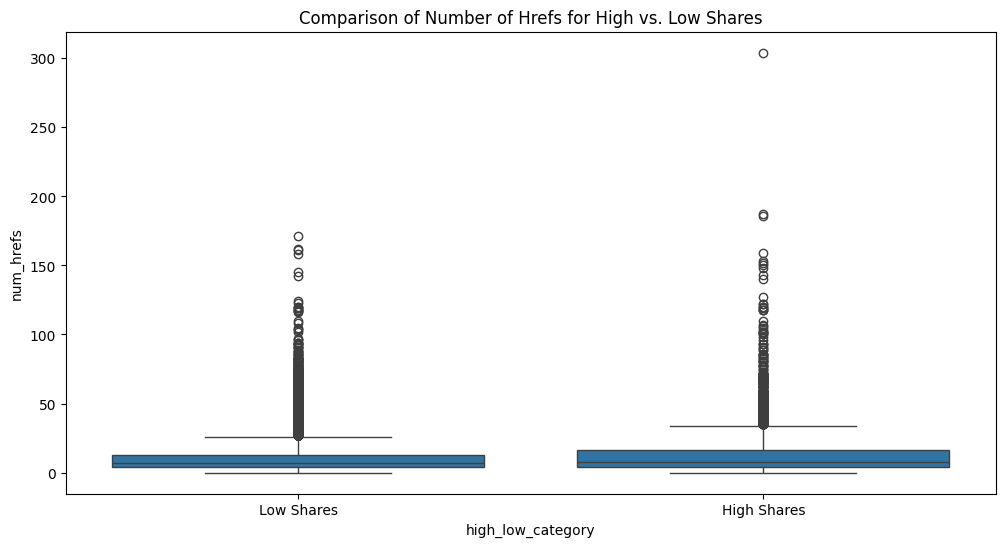

shares_category
Medium-Low     10152
Medium-High     9932
Low             9930
High            9630
Name: count, dtype: int64


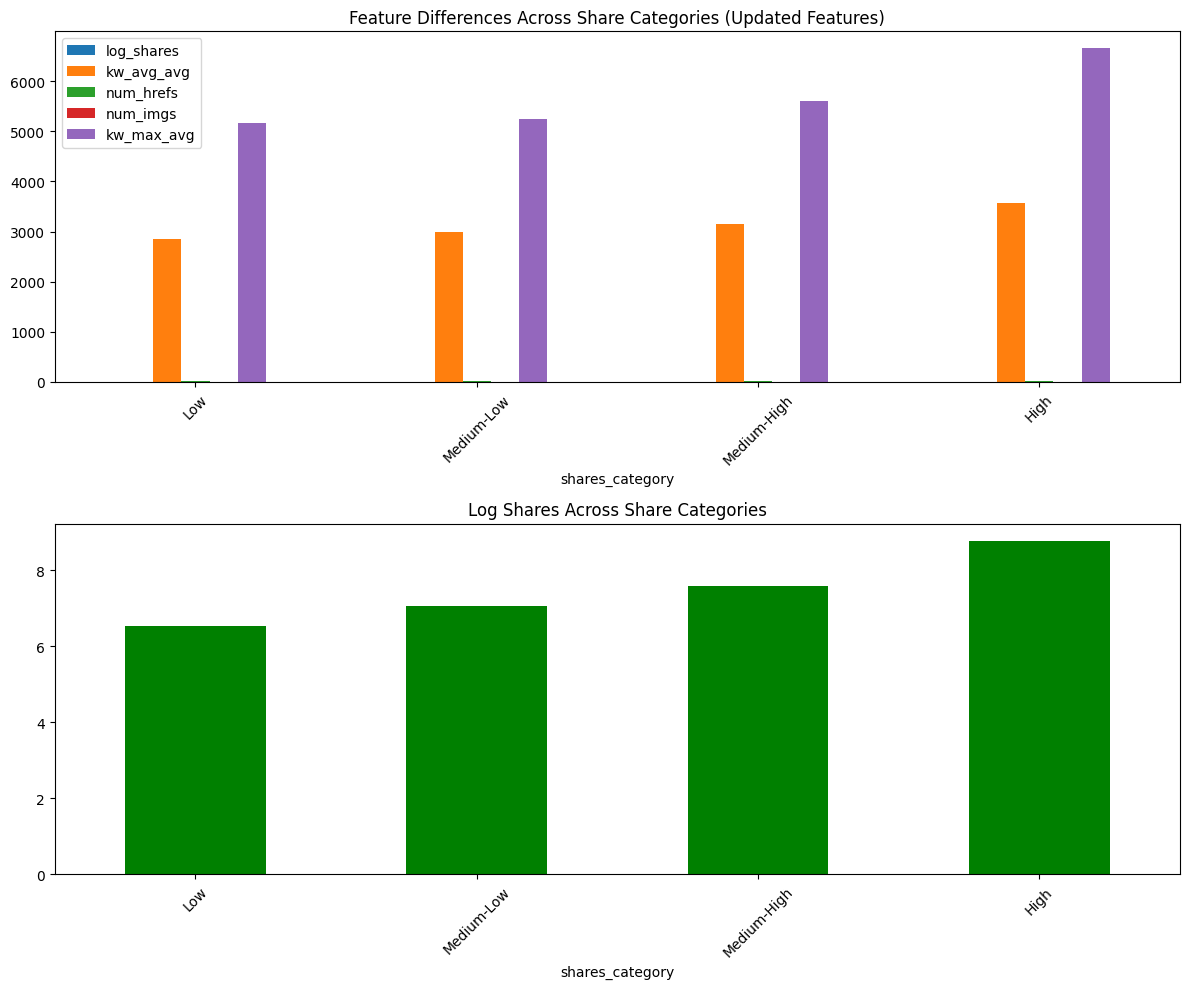

n_tokens_title: 0.16532037674928027
n_tokens_content: 2.9454219387867084
n_unique_tokens: 198.65511559825592
n_non_stop_words: 198.7924453768874
n_non_stop_unique_tokens: 198.44329440926512
num_hrefs: 4.013494828201318
num_self_hrefs: 5.172751105757634
num_imgs: 3.9465958446535474
num_videos: 7.0195327862958665
average_token_length: -4.57601155020474
num_keywords: -0.14725125199950523
data_channel_is_lifestyle: 3.9930191433554167
data_channel_is_entertainment: 1.68358480940472
data_channel_is_bus: 1.8768701859879158
data_channel_is_socmed: 3.758879630973088
data_channel_is_tech: 1.6199757646890423
data_channel_is_world: 1.4051693841208097
kw_min_min: 2.3749472801825444
kw_max_min: 35.32843373115432
kw_avg_min: 31.306108102660584
kw_min_max: 10.386371634782769
kw_max_max: -2.6449817621966782
kw_avg_max: 0.6243096463608944
kw_min_avg: 0.4679758464905322
kw_max_avg: 16.41166955537124
kw_avg_avg: 5.760177291618559
self_reference_min_shares: 26.264364160300094
self_reference_max_shares: 13.

In [4]:
# -*- coding: utf-8 -*-
"""
完整代码示例：从数据加载、预处理到神经网络建模与调参
"""

# -------------------------------
# 导入必要的库
# -------------------------------
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import warnings
warnings.filterwarnings('ignore')

from scipy.stats import boxcox, zscore
from sklearn.preprocessing import StandardScaler, LabelEncoder, PowerTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from scikeras.wrappers import KerasClassifier
# from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# -------------------------------
# Step 1: 加载数据
# -------------------------------
file_path = "OnlineNewsPopularity.csv"
df = pd.read_csv(file_path)
df.columns = df.columns.str.strip()

print("Dataset Information:")
df.info()
print("\nFirst 5 rows:")
print(df.head())

# -------------------------------
# Step 2: 检查缺失值
# -------------------------------
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]
if not missing_values.empty:
    print("\nMissing Values:")
    print(missing_values)
else:
    print("\nNo missing values found in the dataset.")

# -------------------------------
# Step 3: 可视化目标变量 "shares" 的分布
# -------------------------------
plt.figure(figsize=(12, 6))
sns.histplot(df['shares'], bins=50, kde=True)
plt.title("Distribution of Shares")
plt.xlabel("Shares")
plt.ylabel("Frequency")
plt.show()

# -------------------------------
# Step 4: 对 "shares" 进行 log 转换以处理偏态
# -------------------------------
df['log_shares'] = np.log1p(df['shares'])
plt.figure(figsize=(12, 6))
sns.histplot(df['log_shares'], bins=50, kde=True)
plt.title("Log-transformed Distribution of Shares")
plt.xlabel("Log Shares")
plt.ylabel("Frequency")
plt.show()

# -------------------------------
# Step 5: 对 "shares" 进行 Box-Cox 转换
# -------------------------------
df['boxcox_shares'], lambda_val = boxcox(df['shares'] + 1)  # 加1以处理0值
print(f"Optimal lambda for Box-Cox: {lambda_val}")
plt.figure(figsize=(12, 6))
sns.histplot(df['boxcox_shares'], bins=50, kde=True)
plt.title("Box-Cox Transformed Distribution of Shares")
plt.xlabel("Box-Cox Shares")
plt.ylabel("Frequency")
plt.show()

# -------------------------------
# Step 6: 数值型特征相关性热力图
# -------------------------------
numeric_df = df.select_dtypes(include=['number'])
corr_matrix = numeric_df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=False, linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.show()

# -------------------------------
# Step 7: 输出最相关的特征对（排除自相关）
# -------------------------------
high_corr_pairs = corr_matrix.unstack().sort_values(ascending=False)
print("Top correlated feature pairs (excluding self-correlation):")
print(high_corr_pairs[high_corr_pairs < 1].head(10))

# -------------------------------
# Step 8: 分析星期一对分享数的影响
# -------------------------------
plt.figure(figsize=(10, 5))
sns.boxplot(x='weekday_is_monday', y='shares', data=df)
plt.title("Effect of Monday Publication on Shares")
plt.show()

# -------------------------------
# Step 9: 分析不同数据频道对分享数的影响
# -------------------------------
channels = ['data_channel_is_lifestyle', 'data_channel_is_entertainment',
            'data_channel_is_bus', 'data_channel_is_socmed',
            'data_channel_is_tech', 'data_channel_is_world']
df['data_channel'] = df[channels].idxmax(axis=1)
df['data_channel'] = df['data_channel'].str.replace('data_channel_is_', '')

plt.figure(figsize=(10, 6))
sns.barplot(x=df['data_channel'], y=df['shares'], estimator=np.mean, errorbar=None)
plt.title("Average Shares by Data Channel")
plt.xlabel("Data Channel")
plt.ylabel("Average Shares")
plt.xticks(rotation=45)
plt.show()

# -------------------------------
# Step 10: 散点图展示文章长度与分享数的关系
# -------------------------------
plt.figure(figsize=(10, 6))
sns.scatterplot(x='n_tokens_content', y='shares', data=df)
plt.title("Article Length vs. Shares")
plt.show()

# -------------------------------
# Step 11: 部分数值特征的箱线图
# -------------------------------
numerical_features = ['n_tokens_content', 'num_hrefs', 'num_imgs', 'num_videos']
plt.figure(figsize=(12, 8))
df[numerical_features].boxplot()
plt.xticks(rotation=45)
plt.title("Boxplot of Selected Numerical Features")
plt.show()

# -------------------------------
# Step 12: 使用 IQR 与 Z-score 方法检测异常值
# -------------------------------
Q1 = df['shares'].quantile(0.25)
Q3 = df['shares'].quantile(0.75)
IQR = Q3 - Q1
outliers = df[(df['shares'] < (Q1 - 1.5 * IQR)) | (df['shares'] > (Q3 + 1.5 * IQR))]
print(f"Number of outliers using IQR: {len(outliers)}")

df['zscore'] = zscore(df['shares'])
outliers_zscore = df[df['zscore'].abs() > 3]
print(f"Number of outliers using Z-score: {len(outliers_zscore)}")

# -------------------------------
# Step 13: 计算与 shares 的相关性
# -------------------------------
corr_with_shares = numeric_df.corr()['shares'].sort_values(ascending=False)
print(corr_with_shares.head(15))
print(corr_with_shares.tail(15))

# -------------------------------
# Step 14: 根据分享数高低构建类别变量 high_low_category
# -------------------------------
threshold_high = df['shares'].quantile(0.75)
threshold_low = df['shares'].quantile(0.25)
df['high_low_category'] = np.where(df['shares'] > threshold_high, 'High Shares', 'Low Shares')

plt.figure(figsize=(12, 6))
sns.boxplot(x='high_low_category', y='num_hrefs', data=df)
plt.title("Comparison of Number of Hrefs for High vs. Low Shares")
plt.show()

# -------------------------------
# Step 15: 创建用于分组的 shares_category
# -------------------------------
q1 = df['shares'].quantile(0.25)
q2 = df['shares'].quantile(0.5)
q3 = df['shares'].quantile(0.75)
df['shares_category'] = pd.cut(df['shares'],
                               bins=[0, q1, q2, q3, df['shares'].max()],
                               labels=['Low', 'Medium-Low', 'Medium-High', 'High'])
print(df['shares_category'].value_counts())

# -------------------------------
# Step 16: 可视化各分享类别的特征差异
# -------------------------------
fig, axes = plt.subplots(2, 1, figsize=(12, 10))
selected_features = ['log_shares', 'kw_avg_avg', 'num_hrefs', 'num_imgs', 'kw_max_avg']
df.groupby('shares_category')[selected_features].mean().plot(kind='bar', ax=axes[0])
axes[0].set_title("Feature Differences Across Share Categories (Updated Features)")
axes[0].tick_params(axis='x', rotation=45)
df.groupby('shares_category')['log_shares'].mean().plot(kind='bar', ax=axes[1], color='green')
axes[1].set_title("Log Shares Across Share Categories")
axes[1].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

# -------------------------------
# Step 17: 将指定的列转换为布尔型
# -------------------------------
bool_features = [
    "weekday_is_monday",
    "weekday_is_tuesday",
    "weekday_is_wednesday",
    "weekday_is_thursday",
    "weekday_is_friday",
    "weekday_is_saturday",
    "weekday_is_sunday",
    "is_weekend",
    "data_channel_is_lifestyle",
    "data_channel_is_entertainment",
    "data_channel_is_bus",
    "data_channel_is_socmed",
    "data_channel_is_tech",
    "data_channel_is_world"
]
for col in bool_features:
    if col in df.columns:
        df[col] = df[col].astype(bool)
    else:
        print(f"Warning: Column '{col}' not found in DataFrame.")

# -------------------------------
# Step 18: 构建 train 数据（剔除不参与建模的列）
# -------------------------------
train = df.drop(['url', 'timedelta', 'shares_category', 'shares'], axis=1)

# -------------------------------
# Step 19: 查看 train 中各特征的偏度
# -------------------------------
skew_values = {}
for col in train.columns:
    if pd.api.types.is_numeric_dtype(train[col]):
        skew_values[col] = train[col].skew()
    else:
        skew_values[col] = 'N/A'
for feature, skew_val in skew_values.items():
    print(f"{feature}: {skew_val}")

# -------------------------------
# Step 20: 根据预定义偏度对数值特征进行转换
# -------------------------------
# 定义需要跳过转换的布尔型特征
boolean_features = [
    'data_channel_is_lifestyle',
    'data_channel_is_entertainment',
    'weekday_is_monday',
    'weekday_is_tuesday',
    'weekday_is_wednesday',
    'weekday_is_thursday',
    'weekday_is_friday',
    'weekday_is_saturday',
    'weekday_is_sunday',
    'is_weekend',
    'data_channel_is_bus',
    'data_channel_is_socmed',
    'data_channel_is_tech',
    'data_channel_is_world'
]
# 预定义各特征的偏度值（根据你之前的统计结果）
predefined_skew_values = {
    'n_tokens_title': 0.16532037674928027,
    'n_tokens_content': 2.9454219387867084,
    'n_unique_tokens': 198.65511559825592,
    'n_non_stop_words': 198.7924453768874,
    'n_non_stop_unique_tokens': 198.44329440926512,
    'num_hrefs': 4.013494828201318,
    'num_self_hrefs': 5.172751105757634,
    'num_imgs': 3.9465958446535474,
    'num_videos': 7.0195327862958665,
    'average_token_length': -4.57601155020474,
    'num_keywords': -0.14725125199950523,
    'kw_min_min': 2.3749472801825444,
    'kw_max_min': 35.32843373115432,
    'kw_avg_min': 31.306108102660584,
    'kw_min_max': 10.386371634782769,
    'kw_max_max': -2.6449817621966782,
    'kw_avg_max': 0.6243096463608944,
    'kw_min_avg': 0.4679758464905322,
    'kw_max_avg': 16.41166955537124,
    'kw_avg_avg': 5.760177291618559,
    'self_reference_min_shares': 26.264364160300094,
    'self_reference_max_shares': 13.870849049433598,
    'self_reference_avg_sharess': 17.9140933776756,
    'LDA_00': 1.5674632332004765,
    'LDA_01': 2.0867218234169407,
    'LDA_02': 1.311694902028395,
    'LDA_03': 1.2387159863782728,
    'LDA_04': 1.1731294759766238,
    'global_subjectivity': -1.3726888305603973,
    'global_sentiment_polarity': 0.10545709665820545,
    'global_rate_positive_words': 0.32304661115048916,
    'global_rate_negative_words': 1.491917309190822,
    'rate_positive_words': -1.423105853002299,
    'rate_negative_words': 0.4072406539941212,
    'avg_positive_polarity': -0.7247949503201233,
    'min_positive_polarity': 3.0404677374643283,
    'max_positive_polarity': -0.9397564591253907,
    'avg_negative_polarity': -0.55164402900095,
    'min_negative_polarity': -0.07315481617331099,
    'max_negative_polarity': -3.4597470578480207,
    'title_subjectivity': 0.816084749635643,
    'title_sentiment_polarity': 0.39610883665169594,
    'abs_title_subjectivity': -0.6241493828840421,
    'abs_title_sentiment_polarity': 1.7041934399140888,
    'log_shares': 1.0264770065011177,
    'boxcox_shares': -0.2239496211569689,
    'zscore': 33.96388487571418
}

for feature, skewness in predefined_skew_values.items():
    if feature in boolean_features:
        continue  # 跳过布尔型特征
    if feature in df.columns:
        if skewness > 10:  # 极高正偏
            print(f"Applying Yeo-Johnson transformation to {feature} (skewness={skewness:.2f})")
            transformer = PowerTransformer(method='yeo-johnson', standardize=False)
            df[feature] = transformer.fit_transform(df[[feature]])
        elif 2 < skewness <= 10:  # 中等正偏
            print(f"Applying square root transformation to {feature} (skewness={skewness:.2f})")
            df[feature] = np.sqrt(df[feature])
        elif skewness < -10:  # 极高负偏
            print(f"Applying inverse transformation to {feature} (skewness={skewness:.2f})")
            df[feature] = -1 / (df[feature] + 1e-5)
        elif -10 < skewness < -2:  # 中等负偏
            print(f"Applying square root transformation to {feature} (skewness={skewness:.2f})")
            df[feature] = -np.sqrt(-df[feature])
        else:
            print(f"No transformation applied to {feature} (skewness={skewness:.2f})")

print("\nFeature processing completed!")

skew_values = {}
for col in train.columns:
    if pd.api.types.is_numeric_dtype(train[col]):
        skew_values[col] = df[col].skew()
    else:
        skew_values[col] = 'N/A'
for feature, skew_val in skew_values.items():
    print(f"{feature}: {skew_val}")


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39644 entries, 0 to 39643
Data columns (total 63 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   n_tokens_title                 39644 non-null  float64
 1   n_tokens_content               39644 non-null  float64
 2   n_unique_tokens                39644 non-null  float64
 3   n_non_stop_words               39644 non-null  float64
 4   n_non_stop_unique_tokens       39644 non-null  float64
 5   num_hrefs                      39644 non-null  float64
 6   num_self_hrefs                 39644 non-null  float64
 7   num_imgs                       39644 non-null  float64
 8   num_videos                     39644 non-null  float64
 9   average_token_length           39644 non-null  float64
 10  num_keywords                   39644 non-null  float64
 11  data_channel_is_lifestyle      39644 non-null  bool   
 12  data_channel_is_entertainment  39644 non-null 

Epoch 1/100
892/892 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 9.7276 - mean_absolute_error: 2.3110 - val_loss: 19.1483 - val_mean_absolute_error: 1.0908
Epoch 2/100
892/892 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.3491 - mean_absolute_error: 0.8925 - val_loss: 5.0554 - val_mean_absolute_error: 0.5501
Epoch 3/100
892/892 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4579 - mean_absolute_error: 0.5082 - val_loss: 1.5476 - val_mean_absolute_error: 0.3126
Epoch 4/100
892/892 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2058 - mean_absolute_error: 0.3313 - val_loss: 0.5922 - val_mean_absolute_error: 0.1970
Epoch 5/100
892/892 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1318 - mean_absolute_error: 0.2606 - val_loss: 0.2802 - val_mean_absolute_error: 0.1601
Epoch 6/100
892/892 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1045 - mean_absolute_error: 0.2277 - val_loss: 0.3087 - val_mean_absolute_error: 0.1464
Epoch 7/100
892/892 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0840 - mean_absolute_error: 0.

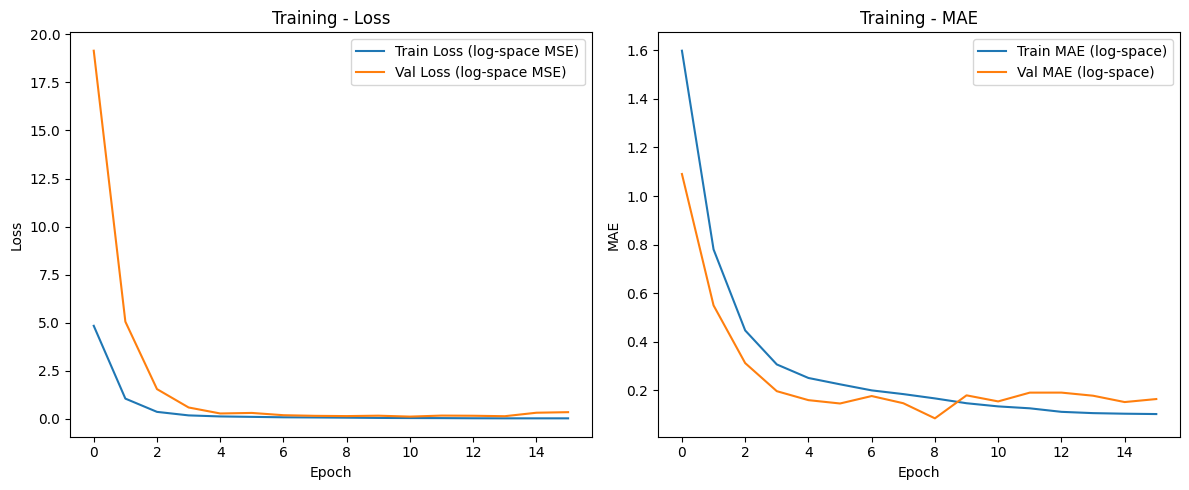

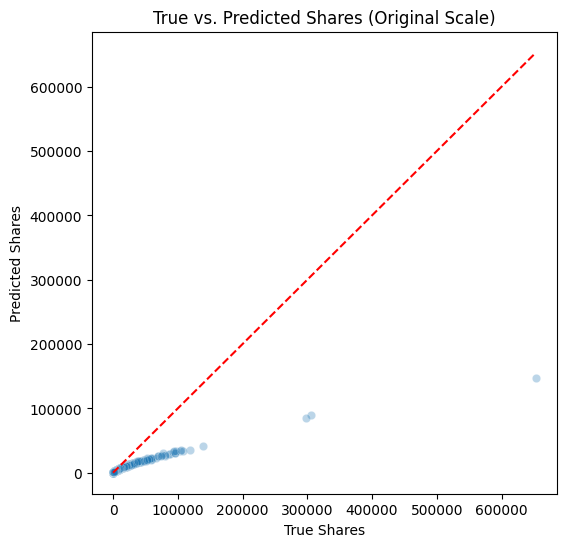

In [6]:
# -------------------------------
# Step 21: Split Data and Train the Neural Network Model (Log-Space)
# -------------------------------

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Assume:
#   1. 'train' is your preprocessed DataFrame (no raw 'shares' column).
#   2. 'df' is the original DataFrame containing 'shares'.

# -------------------------------
# 1. Construct the Feature Matrix (X) and Target (y)
# -------------------------------
X = train.copy()
X = X.drop(['high_low_category', 'data_channel'], axis=1, errors='ignore')

# Transform the target variable to log-space for skewed data
y = np.log1p(df['shares'])  # y = log(1 + shares)

# Standardize the features
scaler = StandardScaler()
X_scaled_all = scaler.fit_transform(X)

# -------------------------------
# 2. Split the Data
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled_all, y, test_size=0.2, random_state=42
)

# -------------------------------
# 3. Build & Compile the Model
# -------------------------------
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.4))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='linear'))  # Output layer for regression

model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='mean_squared_error',
    metrics=['mean_absolute_error']
)

# -------------------------------
# 4. Train the Model with EarlyStopping
# -------------------------------
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stopping],
    verbose=1
)

# -------------------------------
# 5. Evaluate the Model
#    (Revert predictions & labels from log-space to original scale)
# -------------------------------
y_pred_log = model.predict(X_test).flatten()   # Predictions in log-space
y_pred = np.expm1(y_pred_log)                  # Convert back to original scale
y_test_original = np.expm1(y_test)             # Convert test labels to original scale

# (a) MAE, MSE, RMSE on original scale
mae_original = mean_absolute_error(y_test_original, y_pred)
mse_original = mean_squared_error(y_test_original, y_pred)
rmse_original = np.sqrt(mse_original)

print(f"MAE (original scale):  {mae_original:,.2f}")
print(f"MSE (original scale):  {mse_original:,.2f}")
print(f"RMSE (original scale): {rmse_original:,.2f}")

# (b) R² Score (Coefficient of Determination)
r2 = r2_score(y_test_original, y_pred)
print(f"R² (original scale):   {r2:.4f}")

# (c) Optional: Custom 'Accuracy' for Regression
#    For example, fraction of predictions within ±20% of true value
def regression_accuracy(y_true, y_pred, threshold=0.2):
    # threshold=0.2 => within ±20%
    pct_errors = np.abs(y_true - y_pred) / np.clip(y_true, a_min=1e-6, a_max=None)
    return np.mean(pct_errors <= threshold)

acc_20pct = regression_accuracy(y_test_original, y_pred, threshold=0.2)
print(f"Accuracy within ±20%:  {acc_20pct * 100:.2f}%")

# -------------------------------
# 6. Plot Training Curves
# -------------------------------
plt.figure(figsize=(12, 5))

# Loss in log-space
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss (log-space MSE)')
plt.plot(history.history['val_loss'], label='Val Loss (log-space MSE)')
plt.title("Training - Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# MAE in log-space
plt.subplot(1, 2, 2)
plt.plot(history.history['mean_absolute_error'], label='Train MAE (log-space)')
plt.plot(history.history['val_mean_absolute_error'], label='Val MAE (log-space)')
plt.title("Training - MAE")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.legend()

plt.tight_layout()
plt.show()

# -------------------------------
# 7. Scatter Plot of True vs. Predicted (Original Scale)
# -------------------------------
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test_original, y=y_pred, alpha=0.3)
plt.xlabel("True Shares")
plt.ylabel("Predicted Shares")
plt.title("True vs. Predicted Shares (Original Scale)")
plt.plot([0, max(y_test_original)], [0, max(y_test_original)], 'r--')  # Diagonal line
plt.show()


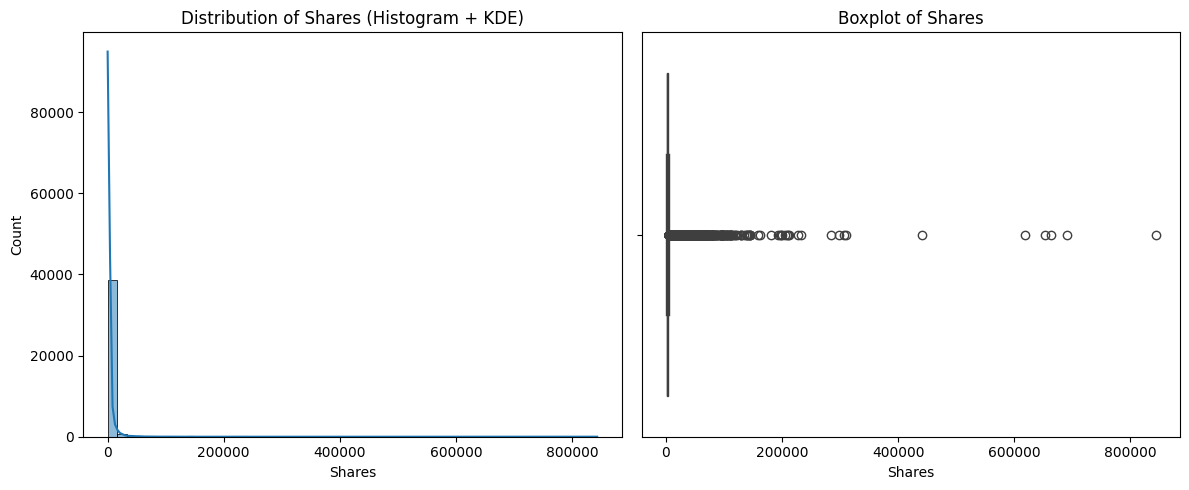

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df['shares'], bins=50, kde=True)
plt.title("Distribution of Shares (Histogram + KDE)")
plt.xlabel("Shares")
plt.ylabel("Count")

plt.subplot(1, 2, 2)
sns.boxplot(x=df['shares'])
plt.title("Boxplot of Shares")
plt.xlabel("Shares")

plt.tight_layout()
plt.show()


Epoch 1/100
892/892 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8713 - loss: 0.3009 - val_accuracy: 0.9858 - val_loss: 0.0660
Epoch 2/100
892/892 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9685 - loss: 0.0808 - val_accuracy: 0.9915 - val_loss: 0.0328
Epoch 3/100
892/892 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9799 - loss: 0.0469 - val_accuracy: 0.9921 - val_loss: 0.0242
Epoch 4/100
892/892 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9836 - loss: 0.0427 - val_accuracy: 0.9924 - val_loss: 0.0193
Epoch 5/100
892/892 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9857 - loss: 0.0327 - val_accuracy: 0.9934 - val_loss: 0.0175
Epoch 6/100
892/892 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9894 - loss: 0.0289 - val_accuracy: 0.9950 - val_loss: 0.0161
Epoch 7/100
892/892 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9922 - loss: 0.0206 - val_accuracy: 0.9953 - val_loss: 0.0120
Epoch 8/100
892/892 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9927 - loss: 0.0209 - val_accu

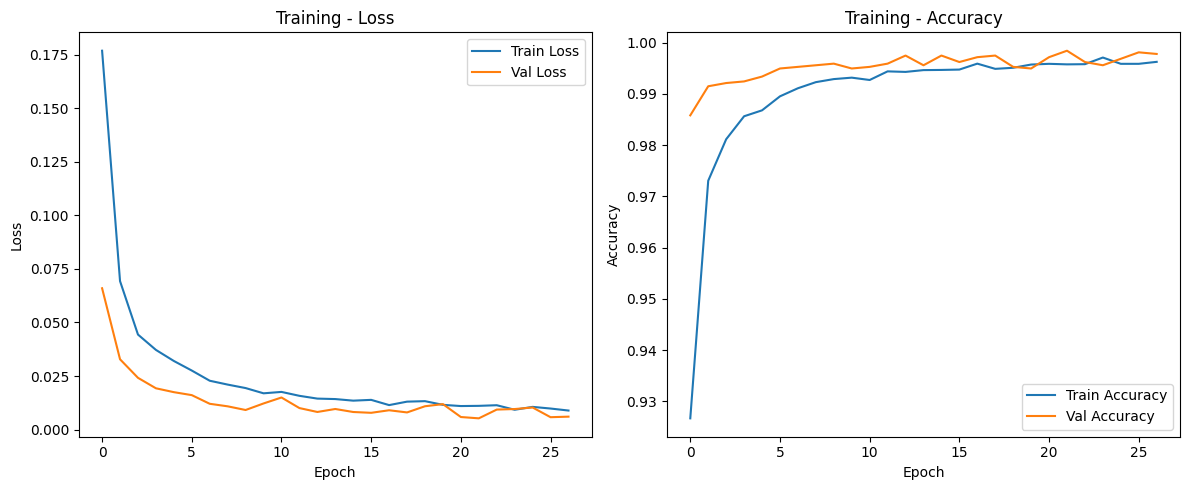

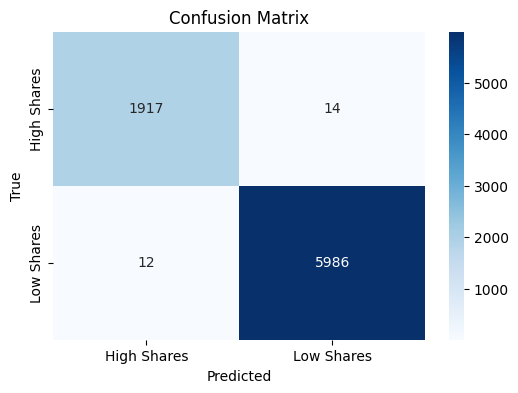

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# -------------------------------
# 1. Prepare the Data
# -------------------------------

# 1.1 Features (X): copy from 'train' DataFrame
X = train.copy()

# Drop columns not needed for modeling (ensure high_low_category is removed)
X = X.drop(['high_low_category', 'data_channel'], axis=1, errors='ignore')

# Optionally, drop any remaining non-numeric columns if you don't plan to encode them:
X = X.select_dtypes(include=[np.number])

# 1.2 Target (y): use 'high_low_category' from df
#    We need to encode it into numeric labels (0/1)
le = LabelEncoder()
y = le.fit_transform(df['high_low_category'])
# For example, "High Shares" -> 1 and "Low Shares" -> 0

# 1.3 Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 1.4 Scale features (neural networks are sensitive to feature scales)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# -------------------------------
# 2. Build & Compile the Classification Model
# -------------------------------

model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)))
model.add(Dropout(0.4))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(16, activation='relu'))
# For binary classification, use 1 neuron with sigmoid activation
model.add(Dense(1, activation='sigmoid'))

model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='binary_crossentropy',   # For 2-class classification
    metrics=['accuracy']          # Track accuracy during training
)

# -------------------------------
# 3. Train the Model with EarlyStopping
# -------------------------------
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    X_train_scaled, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stopping],
    verbose=1
)

# -------------------------------
# 4. Evaluate the Model
# -------------------------------

# 4.1 Predict probabilities on the test set
y_pred_prob = model.predict(X_test_scaled).flatten()

# 4.2 Convert probabilities to binary predictions (0 or 1) using threshold=0.5
threshold = 0.5
y_pred_class = (y_pred_prob >= threshold).astype(int)

# 4.3 Overall Accuracy
acc = accuracy_score(y_test, y_pred_class)
print(f"Test Accuracy: {acc:.4f}")

# 4.4 Confusion Matrix
cm = confusion_matrix(y_test, y_pred_class)
print("Confusion Matrix:")
print(cm)

# 4.5 Classification Report (Precision, Recall, F1-score)
print("Classification Report:")
print(classification_report(y_test, y_pred_class, target_names=le.classes_))

# -------------------------------
# 5. Plot Training Curves
# -------------------------------
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Training - Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Training - Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

# -------------------------------
# 6. Optional: Visualize the Confusion Matrix
# -------------------------------
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


Epoch 1/100
892/892 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8538 - loss: 0.3287 - val_accuracy: 0.9877 - val_loss: 0.0396
Epoch 2/100
892/892 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9704 - loss: 0.0749 - val_accuracy: 0.9905 - val_loss: 0.0258
Epoch 3/100
892/892 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9787 - loss: 0.0562 - val_accuracy: 0.9905 - val_loss: 0.0219
Epoch 4/100
892/892 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9826 - loss: 0.0410 - val_accuracy: 0.9927 - val_loss: 0.0195
Epoch 5/100
892/892 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9868 - loss: 0.0337 - val_accuracy: 0.9909 - val_loss: 0.0186
Epoch 6/100
892/892 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9888 - loss: 0.0287 - val_accuracy: 0.9937 - val_loss: 0.0142
Epoch 7/100
892/892 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9917 - loss: 0.0220 - val_accuracy: 0.9943 - val_loss: 0.0128
Epoch 8/100
892/892 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9920 - loss: 0.0214 - val_accu

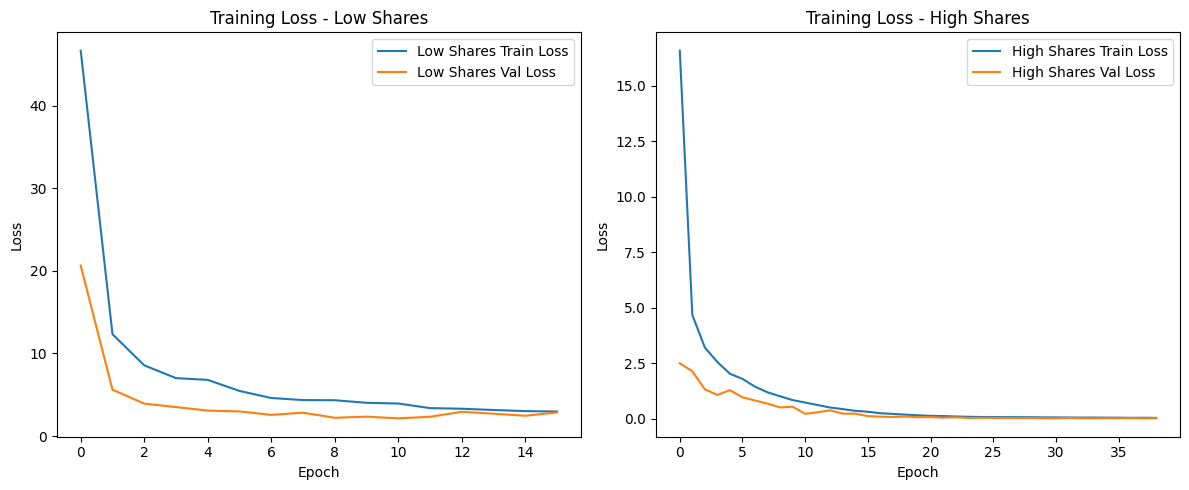

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# -------------------------------
# 1. Classification: Predict High vs. Low Shares
# -------------------------------

# Features (X)
X = train.copy()
X = X.drop(['high_low_category', 'data_channel'], axis=1, errors='ignore')

# Ensure only numeric columns are used
X = X.select_dtypes(include=[np.number])

# Encode the target variable (0 = Low Shares, 1 = High Shares)
le = LabelEncoder()
y_class = le.fit_transform(df['high_low_category'])

# Split into train/test
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(
    X, y_class, test_size=0.2, random_state=42
)

# Standardize features
scaler = StandardScaler()
X_train_class_scaled = scaler.fit_transform(X_train_class)
X_test_class_scaled = scaler.transform(X_test_class)

# Classification Model
model_class = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_class_scaled.shape[1],)),
    Dropout(0.4),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification
])

model_class.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])

# Train classification model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
history_class = model_class.fit(
    X_train_class_scaled, y_train_class,
    epochs=100, batch_size=32,
    validation_split=0.1,
    callbacks=[early_stopping],
    verbose=1
)

# Predict class labels on test set
y_pred_class_prob = model_class.predict(X_test_class_scaled).flatten()
y_pred_class = (y_pred_class_prob >= 0.5).astype(int)

# Classification Performance
print("\nClassification Report:\n", classification_report(y_test_class, y_pred_class, target_names=le.classes_))

# -------------------------------
# 2. Split Data Based on Classification Results
# -------------------------------
df_test = df.iloc[X_test_class.index].copy()  # Retrieve original shares data
df_test['predicted_category'] = y_pred_class

# Separate data into Low Shares and High Shares for regression
# only selecting test set indicies to keep everything aligned
test_low_shares_indices = df_test.iloc[y_pred_class == 0].index
test_high_shares_indices = df_test.iloc[y_pred_class == 1].index

X_low = X.loc[test_low_shares_indices]
X_high = X.loc[test_high_shares_indices]
y_low = np.log1p(df.loc[test_low_shares_indices, 'shares'])  # Log-transform for better regression
y_high = np.log1p(df.loc[test_high_shares_indices, 'shares'])

# Train-test split for both categories
X_train_low, X_test_low, y_train_low, y_test_low = train_test_split(X_low, y_low, test_size=0.2, random_state=42)
X_train_high, X_test_high, y_train_high, y_test_high = train_test_split(X_high, y_high, test_size=0.2, random_state=42)

# Standardize separately for each regression model
scaler_low = StandardScaler()
X_train_low_scaled = scaler_low.fit_transform(X_train_low)
X_test_low_scaled = scaler_low.transform(X_test_low)

scaler_high = StandardScaler()
X_train_high_scaled = scaler_high.fit_transform(X_train_high)
X_test_high_scaled = scaler_high.transform(X_test_high)

# -------------------------------
# 3. Train Separate Regression Models
# -------------------------------

# Define function for building regression model
def build_regression_model():
    model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train_low.shape[1],)),
        Dropout(0.4),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(16, activation='relu'),
        Dense(1, activation='linear')  # Regression output
    ])
    model.compile(optimizer=Adam(learning_rate=1e-3), loss='mean_squared_error', metrics=['mean_absolute_error'])
    return model

# Train Low Shares Model
model_low = build_regression_model()
history_low = model_low.fit(
    X_train_low_scaled, y_train_low,
    epochs=100, batch_size=32,
    validation_split=0.1,
    callbacks=[early_stopping],
    verbose=1
)

# Train High Shares Model
model_high = build_regression_model()
history_high = model_high.fit(
    X_train_high_scaled, y_train_high,
    epochs=100, batch_size=32,
    validation_split=0.1,
    callbacks=[early_stopping],
    verbose=1
)

# -------------------------------
# 4. Evaluate Regression Models
# -------------------------------

# Predict & Invert log-transformation
y_pred_low_log = model_low.predict(X_test_low_scaled).flatten()
y_pred_low = np.expm1(y_pred_low_log)

y_pred_high_log = model_high.predict(X_test_high_scaled).flatten()
y_pred_high = np.expm1(y_pred_high_log)

y_test_low_original = np.expm1(y_test_low)
y_test_high_original = np.expm1(y_test_high)

# Compute regression metrics
mae_low = mean_absolute_error(y_test_low_original, y_pred_low)
mae_high = mean_absolute_error(y_test_high_original, y_pred_high)

print(f"\nLow Shares MAE: {mae_low:.2f}")
print(f"High Shares MAE: {mae_high:.2f}")

# -------------------------------
# 5. Final Predictions & Combination
# -------------------------------

# Add a 'predicted_shares' column to df_test and populate
df_test['predicted_shares'] = np.nan
df_test.loc[X_test_low.index, 'predicted_shares'] = y_pred_low
df_test.loc[X_test_high.index, 'predicted_shares'] = y_pred_high

# -------------------------------
# 6. Plot Training Curves for Regression Models
# -------------------------------

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_low.history['loss'], label='Low Shares Train Loss')
plt.plot(history_low.history['val_loss'], label='Low Shares Val Loss')
plt.title("Training Loss - Low Shares")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_high.history['loss'], label='High Shares Train Loss')
plt.plot(history_high.history['val_loss'], label='High Shares Val Loss')
plt.title("Training Loss - High Shares")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()